# MEG Data Preprocessing Pipeline - Subject 95

## Overview
This notebook implements a standardized preprocessing pipeline for OPM-MEG data analysis. The pipeline is designed for **subject sub-95** (healthy participant)
and processes one session at a time through a modular, reusable framework.

## Research Context
- **Subject**: sub-95 (healthy control participant)
- **Data Type**: OPM-MEG recordings (.fif format)


## 0 - Libraries:

In [40]:
# ---- LIBRARIES ----
import json
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from mne.preprocessing import compute_proj_hfc

sys.path.append('../source')
from find_paths import get_onedrive_path
from plot_functions import (plot_raw_vs_processed,
                            plot_channels_comparison,)

## 1. Define settings and load data (incl epoched events)


### 1.1- Path Setup:

In [41]:
# Get base data path

base_data_path = get_onedrive_path('data')
print("Base data path found successfully")
print(f"Base path: {base_data_path}")


project folder found: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG
Base data path found successfully
Base path: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG/data


### 1.2 Load configuration


In [42]:
# ---- 1.2 LOAD CONFIGURATION  ----
# 1. Load configuration
config_path = '../configs/config_sub95.json'
with open(config_path, 'r') as f:
    config = json.load(f)['Version-1']

# 2. Show available tasks from the config file
available_tasks = config.get('tasks', [])
print("="*60)
print("Available tasks in the configuration file:")
print("="*60)
for task in available_tasks:
    print(f"- {task}")
print("="*60)


Available tasks in the configuration file:
- emptyroom
- emptyroom2
- emptyroompluscamera
- restfederico1
- behavfederico1
- withemgacc


### 1.3 Load Data:

In [43]:
# 3. Define the task for this run (select one from the list above)
TASK = 'withemgacc' 

# 4. Retrieve settings from config
SUBJECT_ID = config['subject_id']
timestamps = config['timestamps']
TIMESTAMP = timestamps.get(TASK)

# 5. Build the file path
file_structure = config['file_structure']['source_data']
filename = file_structure['filename_pattern'].format(timestamp=TIMESTAMP, task=TASK)
file_path = os.path.join(
        base_data_path,
        file_structure['base_folder'],
        SUBJECT_ID,
        file_structure['subfolder'],
        filename
    )

    # 6. Verify and display the results
print(f"\n--> Proceeding with selected task: '{TASK}'")
print(f"--> Constructed Filename: {filename}")
print(f"--> Full Path: {file_path}")
print(f"--> File exists: {os.path.exists(file_path)}")
print("="*60)


--> Proceeding with selected task: 'withemgacc'
--> Constructed Filename: 20250911_144603_sub-test01_file-withemgacc_raw.fif
--> Full Path: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG/data/source_data/sub-95/OPM_MEG/20250911_144603_sub-test01_file-withemgacc_raw.fif
--> File exists: True


### 1.4 Data Info:

In [44]:
# ---- 1.4 LOAD AND EXPLORE DATA ----


raw = mne.io.read_raw_fif(file_path, preload=True, verbose='WARNING')
print("File loaded successfully.")

# Display the data header (raw.info)
print("\n" + "="*60)
print("DATA HEADER:")
print("="*60)
print(raw.info)

File loaded successfully.

DATA HEADER:
<Info | 16 non-empty values
 bads: []
 ch_names: L105_by-s99, L105_bz-s99, L107_by-s103, L107_bz-s103, ...
 chs: 184 Magnetometers, 1 Stimulus
 custom_ref_applied: False
 description: {"chassis":{"version":"0.10.14- ...
 dig: 6 items (3 Cardinal, 3 HPI)
 file_id: 4 items (dict)
 gantry_angle: 0.0
 highpass: 0.0 Hz
 line_freq: 0.0
 lowpass: 500.0 Hz
 meas_date: 2025-09-11 12:46:03 UTC
 meas_id: 4 items (dict)
 nchan: 185
 proj_id: 1 item (ndarray)
 proj_name: LIDOPM
 projs: []
 sfreq: 1000.0 Hz
 xplotter_layout: None
>


In [45]:
# From the raw.info, extract and display the sampling frequency (sfreq):

SFREQ = raw.info['sfreq']
print("="*60)
print(f"Sampling Frequency (sfreq): {SFREQ} Hz")
print("="*60)

Sampling Frequency (sfreq): 1000.0 Hz


### 1.5 Verify Sensor Geometry

The plot displays:
-   **Sensor Positions**: Each sensor's location in 3D space, shown as a black dot.
-   **Orientation Vectors**: The local coordinate system of each sensor, represented by three colored arrows:
    -   **Red**: The sensor's local X-axis.
    -   **Green**: The sensor's local Y-axis.
    -   **Blue**: The sensor's local Z-axis (normal vector, pointing away from the head).


DETAILED 3D SENSOR GEOMETRY VERIFICATION
Plotting sensor positions and orientation vectors from raw.info.


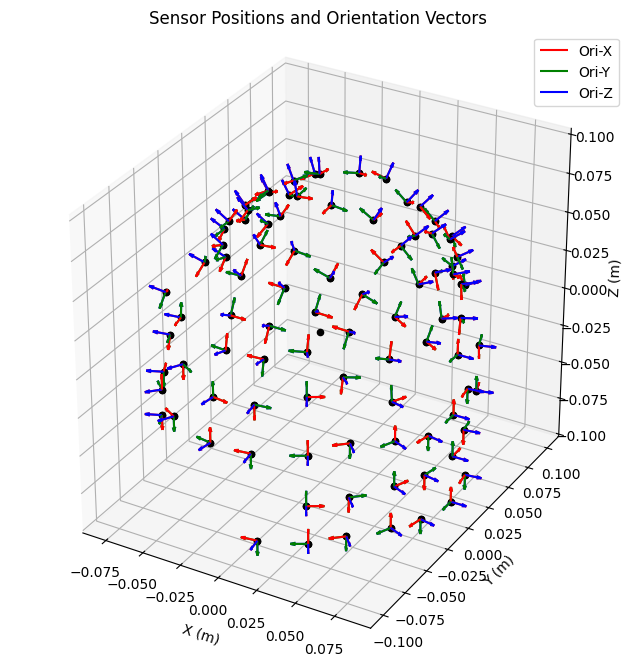

In [46]:
print("\n" + "="*60)
print("DETAILED 3D SENSOR GEOMETRY VERIFICATION")
print("="*60)
print("Plotting sensor positions and orientation vectors from raw.info.")

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Get channel names from the raw object
chnames = raw.ch_names

for ch_name in chnames:
    # Find the channel's dictionary in the info structure
    ch_info = raw.info['chs'][raw.ch_names.index(ch_name)]
    
    # Extract position and all THREE orientation vectors from the 'loc' array
    pos = ch_info['loc'][:3]    # Position (x, y, z)
    ori_x = ch_info['loc'][3:6]  # First orientation vector (X-axis)
    ori_y = ch_info['loc'][6:9]  # Second orientation vector (Y-axis)
    ori_z = ch_info['loc'][9:12] # Third orientation vector (Z-axis, normal)
    
    # Plot sensor location
    ax.scatter(*pos, c='black', s=20)

    # Plot orientation vectors (scaled for visibility)
    scale = 0.01  # Adjust scale if vectors are too long or short
    ax.quiver(*pos, *ori_x, length=scale, color='red', label='Ori-X' if ch_name == chnames[0] else "")
    ax.quiver(*pos, *ori_y, length=scale, color='green', label='Ori-Y' if ch_name == chnames[0] else "")
    ax.quiver(*pos, *ori_z, length=scale, color='blue', label='Ori-Z' if ch_name == chnames[0] else "")

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title("Sensor Positions and Orientation Vectors")
ax.legend()

# Set aspect ratio to be equal
ax.set_box_aspect([np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())])

plt.show()

### 1.6 Define channel lists from config file:

### Note on Available MEG Components

For this specific dataset, the raw `.fif` files contain only the **Y and Z magnetic field components** from the OPM sensors. This is the expected format for this recording, and the subsequent analysis will proceed using these two available components.

In [47]:
# ---- 1.6 DEFINE CHANNEL LISTS FROM CONFIG ----

# Dynamically identify MEG channels from the raw data based on naming convention
meg_channels_y = [ch_name for ch_name in raw.ch_names if '_by' in ch_name]
meg_channels_z = [ch_name for ch_name in raw.ch_names if '_bz' in ch_name]
all_meg_channels = meg_channels_y + meg_channels_z

# Verify that channels were found
if not all_meg_channels:
    raise RuntimeError("No MEG channels with '_by' or '_bz' found in the data. Please check channel names.")

# Select the MEG data from the raw file
meg_data = raw.copy().pick(all_meg_channels)

#To visualize the effects of our preprocessing, we'll create a copy of the selected MEG data 
# before any filtering or resampling.
meg_data_unprocessed = meg_data.copy()

print("\n" + "="*60)
print("MEG CHANNEL SELECTION")
print("="*60)
print(f"Selected {len(meg_data.ch_names)} MEG channels out of {len(raw.ch_names)} total channels.")
print("="*60)


MEG CHANNEL SELECTION
Selected 184 MEG channels out of 185 total channels.


## 2. Preprocessing: Resampling and Filtering

### 2.1 Load preprocessing settings and resample:

In [48]:
# ---- 2.1 LOAD PREPROCESSING SETTINGS AND RESAMPLE ----

# Load the general preprocessing settings
with open('../configs/preproc_settings_v1.json', 'r') as f:
    preproc_settings = json.load(f)

TARGET_SFREQ = preproc_settings['TARGET_SFREQ']

# Resample the data if the original sampling frequency is higher than the target
print("\n" + "="*60)
print("RESAMPLING DATA")
print("="*60)
print(f"Original sampling rate: {meg_data.info['sfreq']} Hz.")
meg_data.resample(TARGET_SFREQ, npad='auto')
print(f"New sampling rate: {meg_data.info['sfreq']} Hz")



RESAMPLING DATA
Original sampling rate: 1000.0 Hz.
New sampling rate: 512.0 Hz


### 2.2 Apply bandpass and notch filters:

In [49]:
# ---- 2.2 APPLY BANDPASS AND NOTCH FILTERS ----

# Extract filter parameters from the settings file
BANDPASS_LOW = preproc_settings['BANDPASS_LOW']
BANDPASS_HIGH = preproc_settings['BANDPASS_HIGH']
NOTCH_FREQS = preproc_settings['NOTCH_FREQS']

print("\n" + "="*60)
print("APPLYING FILTERS")
print("="*60)

# Apply bandpass filter
print(f"Applying bandpass filter between {BANDPASS_LOW} Hz and {BANDPASS_HIGH} Hz...")
meg_data.filter(
    l_freq=BANDPASS_LOW,
    h_freq=BANDPASS_HIGH,
    method='fir',
    verbose=False
)

# Apply notch filter to remove power line noise
print(f"Applying notch filter at {NOTCH_FREQS} Hz...")
meg_data.notch_filter(
    freqs=NOTCH_FREQS,
    verbose=False
)

print("Filtering complete.")
print("="*60)


APPLYING FILTERS
Applying bandpass filter between 2 Hz and 95 Hz...
Applying notch filter at [50, 100] Hz...
Filtering complete.


### 2.3 Homogeneous Field Correction (HFC)

Next, we apply Homogeneous Field Correction (HFC) to suppress external magnetic field interference.

In [50]:
# ---- 2.3 APPLY HOMOGENEOUS FIELD CORRECTION (HFC) ----

# Get HFC order from preprocessing settings
HFC_ORDER = preproc_settings.get('HFC_ORDER', 1) 

print("\n" + "="*60)
print("APPLYING HOMOGENEOUS FIELD CORRECTION (HFC)")
print("="*60)
print(f"Computing HFC projectors with order={HFC_ORDER}...")

# Compute and apply HFC projectors
proj_hfc = compute_proj_hfc(meg_data.info, order=HFC_ORDER)
meg_data.add_proj(proj_hfc)
meg_data.apply_proj()

print("HFC projectors have been applied to the data.")
print("="*60)


APPLYING HOMOGENEOUS FIELD CORRECTION (HFC)
Computing HFC projectors with order=1...
3 projection items deactivated
Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
HFC projectors have been applied to the data.


### 2.4 Visual Comparison: Raw vs. Processed


In [51]:
# ---- PLOT COMPONENTS COMPARISON ----

print("\n" + "="*60)
print("GENERATING COMPARISON PLOT FOR Y-COMPONENTS")
print("="*60)

# Define time window
START_TIME = 0
DURATION = 300
STOP_TIME = START_TIME + DURATION

print(f"Plotting data from {START_TIME}s to {STOP_TIME}s...")


GENERATING COMPARISON PLOT FOR Y-COMPONENTS
Plotting data from 0s to 300s...


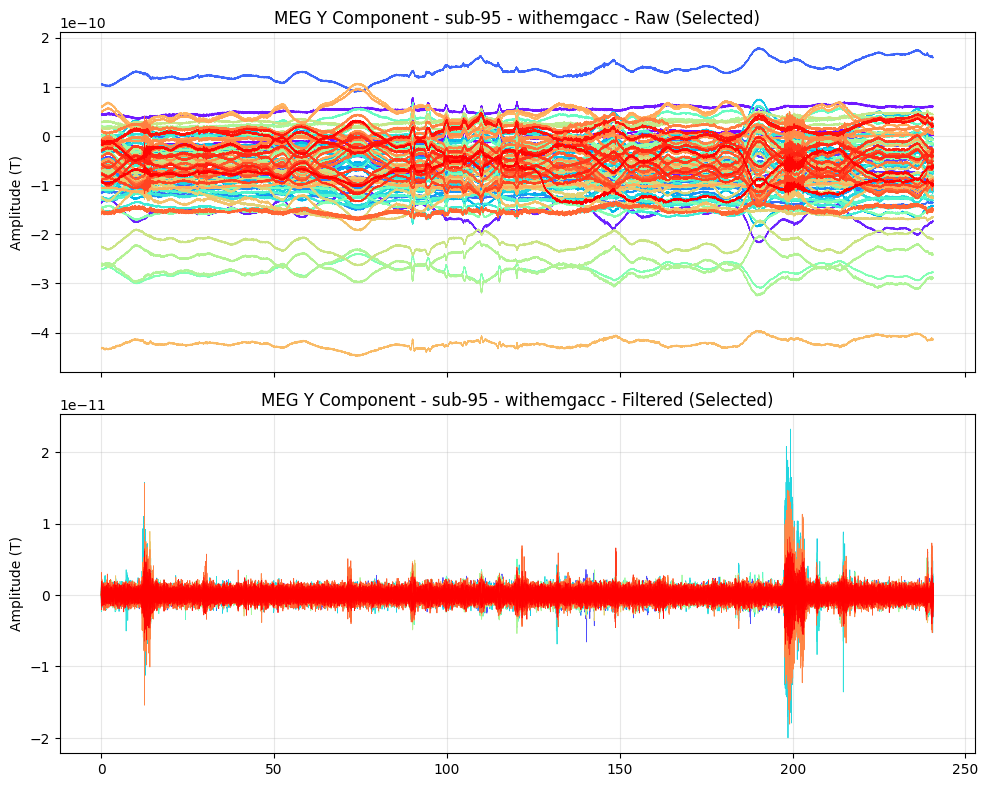

In [52]:
# ---- PLOT Y-COMPONENT COMPARISON ----


# Extract data and time for the plot for Y-components
# Unprocessed data
start_idx_unprocessed = meg_data_unprocessed.time_as_index(START_TIME)[0]
stop_idx_unprocessed = meg_data_unprocessed.time_as_index(STOP_TIME)[0]
y_data_unprocessed = meg_data_unprocessed.get_data(picks=meg_channels_y, start=start_idx_unprocessed, stop=stop_idx_unprocessed)
time_unprocessed = meg_data_unprocessed.times[start_idx_unprocessed:stop_idx_unprocessed]

# Processed data
start_idx_processed = meg_data.time_as_index(START_TIME)[0]
stop_idx_processed = meg_data.time_as_index(STOP_TIME)[0]
y_data_processed = meg_data.get_data(picks=meg_channels_y, start=start_idx_processed, stop=stop_idx_processed)
time_processed = meg_data.times[start_idx_processed:stop_idx_processed]

# Generate colors for the channels
colors_y = plt.cm.rainbow(np.linspace(0, 1, len(meg_channels_y)))

plot_channels_comparison(
    time_0=time_unprocessed,
    time_1=time_processed,
    raw_channels=y_data_unprocessed,
    filtered_channels=y_data_processed,
    raw_labels=meg_channels_y,
    filtered_labels=meg_channels_y,
    colors=colors_y,
    rec_label=f"{SUBJECT_ID} - {TASK}",
    y_label="Amplitude (T)",
    axis_label="Y",
    sync_ylim=False,
    show_legend=False

)


GENERATING COMPARISON PLOT FOR Z-COMPONENTS


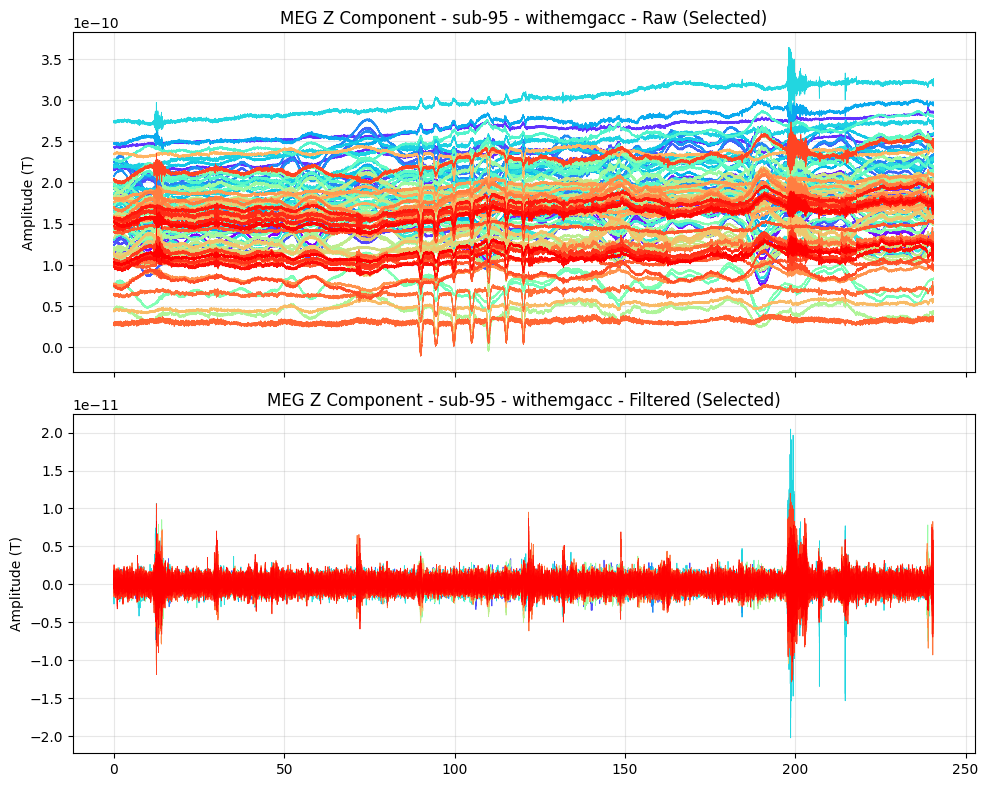

In [53]:
# ---- PLOT Z-COMPONENT COMPARISON ----

print("\n" + "="*60)
print("GENERATING COMPARISON PLOT FOR Z-COMPONENTS")
print("="*60)

# Extract data and time for the plot for Z-components
z_data_unprocessed = meg_data_unprocessed.get_data(picks=meg_channels_z, start=start_idx_unprocessed, stop=stop_idx_unprocessed)
z_data_processed = meg_data.get_data(picks=meg_channels_z, start=start_idx_processed, stop=stop_idx_processed)

# Generate colors for the channels
colors_z = plt.cm.rainbow(np.linspace(0, 1, len(meg_channels_z)))

plot_channels_comparison(
    time_0=time_unprocessed,
    time_1=time_processed,
    raw_channels=z_data_unprocessed,
    filtered_channels=z_data_processed,
    raw_labels=meg_channels_z,
    filtered_labels=meg_channels_z,
    colors=colors_z,
    rec_label=f"{SUBJECT_ID} - {TASK}",
    y_label="Amplitude (T)",
    axis_label="Z",
    sync_ylim=False,
    show_legend=False

)

## 3. Create Epochs from Events

For the `withemgacc` task, the event trigger signals were not recorded on a standard trigger channel within the `.fif` file. Instead, they were saved to a separate `.trg` file, which is only available for this specific recording session.

To ensure a self-contained and reproducible analysis, the timestamps from this `.trg` file have been manually extracted and stored within the `config_sub95.json` file under the `event_timestamps` key. The following cells load these pre-defined timestamps from the configuration to create the event markers for epoching.

In [54]:
# ---- 3.1 LOAD EVENT TIMESTAMPS FROM CONFIG ----

print("\n" + "="*60)
print(f"LOADING EVENT TIMESTAMPS FOR TASK: '{TASK}'")
print("="*60)

try:
    # Get event timestamps from the loaded configuration file for the current task
    event_times = np.array(config['event_timestamps'][TASK])
    
    if event_times.size == 0:
        raise ValueError(f"No event timestamps found for task '{TASK}' in the config file.")
    
    print(f"Successfully loaded {len(event_times)} event timestamps from config.")
    print("Event times (in seconds):")
    print(event_times)

except KeyError:
    print(f"Error: 'event_timestamps' or task '{TASK}' not found in the config file.")
    event_times = np.array([]) # Ensure event_times exists but is empty
except Exception as e:
    print(f"An error occurred: {e}")
    event_times = np.array([])

print("="*60)


LOADING EVENT TIMESTAMPS FOR TASK: 'withemgacc'
Successfully loaded 5 event timestamps from config.
Event times (in seconds):
[ 18.091  85.671 127.289 183.421 226.357]


In [55]:
# ---- 3.2 CREATE MNE-COMPATIBLE EVENTS ARRAY ----

print("\n" + "="*60)
print("CREATING MNE EVENTS ARRAY FROM TIMESTAMPS")
print("="*60)

if event_times.size > 0:
    # MNE requires event markers as sample indices, not seconds.
    # We convert the timestamps in seconds to sample indices by multiplying by the sampling frequency.
    # We use the sampling frequency from the unprocessed data to ensure perfect alignment.
    sfreq_unprocessed = meg_data_unprocessed.info['sfreq']
    event_samples = (event_times * sfreq_unprocessed).astype(int)
    print(f"Converted {len(event_times)} event timestamps (in seconds) to sample indices using sfreq={sfreq_unprocessed} Hz.")

    # The MNE events array has 3 columns: [sample_index, previous_event_id, event_id].
    # We will use a single event_id (1) for all our triggers.
    events_array = np.array([event_samples, np.zeros_like(event_samples), np.ones_like(event_samples)]).T

    print(f"\nCreated events array with shape: {events_array.shape}")
    print("This array contains ALL events.")
    print("Showing the full array for verification:")
    print(events_array)
else:
    print("Skipping MNE event array creation because no event times were loaded.")
    events_array = np.array([])

print("="*60)


CREATING MNE EVENTS ARRAY FROM TIMESTAMPS
Converted 5 event timestamps (in seconds) to sample indices using sfreq=1000.0 Hz.

Created events array with shape: (5, 3)
This array contains ALL events.
Showing the full array for verification:
[[ 18091      0      1]
 [ 85671      0      1]
 [127289      0      1]
 [183421      0      1]
 [226357      0      1]]


In [56]:
# ---- 3.3 CREATE EPOCHS FROM EVENTS ----

print("\n" + "="*60)
print("CREATING EPOCHS FROM EVENTS ARRAY")
print("="*60)

if events_array.size > 0:
    # Define epoching parameters from the preprocessing settings
    TMIN = preproc_settings.get('EPOCH_TMIN', -1.0)  # Start time before event
    TMAX = preproc_settings.get('EPOCH_TMAX', 3.0)   # End time after event
    BASELINE = tuple(preproc_settings.get('EPOCH_BASELINE', [-1.0, 0])) # Baseline period

    # Create epochs from the preprocessed data using the full events_array
    epochs = mne.Epochs(
        meg_data,
        events=events_array,
        tmin=TMIN,
        tmax=TMAX,
        baseline=BASELINE,
        preload=True,  # Load all epoch data into memory
        verbose=False
    )

    print(f"Successfully created {len(epochs)} epochs.")
    print(f"Each epoch runs from {TMIN}s to {TMAX}s relative to the event.")
    print(f"Baseline correction was applied using the interval {BASELINE}s.")
    print("="*60)

    # You can now inspect the epochs object
    print("\nEpochs object info:")
    print(epochs)

else:
    print("Skipping epoch creation because no events were found.")
    epochs = None

print("="*60)


CREATING EPOCHS FROM EVENTS ARRAY
Successfully created 2 epochs.
Each epoch runs from -1.0s to 3.0s relative to the event.
Baseline correction was applied using the interval (-1.0, 0)s.

Epochs object info:
<Epochs | 2 events (all good), -1 – 3 s (baseline -1 – 0 s), ~5.9 MiB, data loaded,
 '1': 2>
